In [1]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yaml
from gurobipy import *

In [2]:
def Read_data(SCALE, FILE_ID):
    FILE_ID = str(FILE_ID)
    
    FILE_PATH = './instance/' + SCALE + '/instance_' + SCALE + '_' + FILE_ID + '.yaml'
    with open(FILE_PATH, 'r') as file:
        DATA = yaml.safe_load(file)

    return DATA

def Plot_data(DATA):

    NET_SIZE = DATA['NET_SIZE']

    # FACILITY
    CANDIDATES = DATA['CANDIDATES']
    J = DATA['j_amount']

    # CAR TYPE
    K = DATA['k_amount']
    V = DATA['V']

    # COMPETITORS
    COMPETITORS = DATA['COMPETITORS']
    L = DATA['l_amount']
    A_c = DATA['A_opponent_bar']


    # CONSUMERS
    I = DATA['i_amount']
    CONSUMERS = DATA['CONSUMERS']
    H = DATA['H']

    # DISTANCE
    D = DATA['D']
    D_c = DATA['D_comp']


    # COST
    F = DATA['F']
    C = DATA['C']
    B = DATA['B']

    # BOUND
    U_LT = DATA['U_LT']
    U_T = DATA['U_T']
    U_L = DATA['U_L']

    A_EX_bound = DATA['A_EX_bound']

    plt.plot([x[0] for x in CONSUMERS], [x[1] for x in CONSUMERS], 'r*')
    for i in range(I):
        plt.text(CONSUMERS[i][0], CONSUMERS[i][1]+0.1, 'comsumer(H_i: ' + str(H[i]) + ')', color='r')
    plt.plot([x[0] for x in COMPETITORS], [x[1] for x in COMPETITORS], 'b+')
    for l in range(L):
        plt.text(COMPETITORS[l][0], COMPETITORS[l][1]+0.1, 'competitor(A^: ' + str(A_c[l]) + ')', color='b')
    plt.plot([x[0] for x in CANDIDATES], [x[1] for x in CANDIDATES], '+')
    
def Original_refined(DATA, show_detail=True):

    NET_SIZE = DATA['NET_SIZE']

    # FACILITY
    CANDIDATES = DATA['CANDIDATES']
    J = DATA['j_amount']

    # CAR TYPE
    K = DATA['k_amount']
    V = DATA['V']

    # COMPETITORS
    COMPETITORS = DATA['COMPETITORS']
    L = DATA['l_amount']
    A_c = DATA['A_opponent_bar']


    # CONSUMERS
    I = DATA['i_amount']
    CONSUMERS = DATA['CONSUMERS']
    H = DATA['H']

    # DISTANCE
    D = DATA['D']
    D_c = DATA['D_comp']


    # COST
    F = DATA['F']
    C = DATA['C']
    B = DATA['B']

    # BOUND
    U_LT = DATA['U_LT']
    U_T = DATA['U_T']
    U_L = DATA['U_L']

    A_EX_bound = DATA['A_EX_bound']

    #GUROBI
    m = Model("original_withG_withE_reform")
    if show_detail == False:
        m.Params.LogToConsole = 0


    ## Create variables
    X = []
    for j in range(J):
        temp = []
        for k in range(K):
            temp.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="X_" + str(j) + '_' + str(k)))
        X.append(temp)

    A_EX = []
    for j in range(J):
        A_EX.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="A^X_" + str(j)))

    Y = []
    for j in range(J):
        Y.append(m.addVar(vtype=GRB.BINARY, lb=0, name="Y_" + str(j)))

    E_var = []
    for j in range(J):
        E_var.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=40, name="E_var_" + str(j)))

    G_var = []
    b = []
    for i in range(I):
        G_var.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name="G_var_" + str(i)))
        b.append(m.addVar(vtype=GRB.BINARY, name="b_" + str(i)))

    big_M = 10000
    G_M = 1
    eps = 0.00001

    TA = {}
    for i in range(I):
        TA[i] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="TA_" + str(i))

    W = {}
    for i in range(I):
        W[i] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="W_" + str(i))


    ## Integrate new variables
    m.update()

    ## Set objective
    m.setObjective(quicksum(W[i] for i in range(I)) \
                 - quicksum(F[j]*Y[j] + C[j]*A_EX[j] + quicksum(B[j][k]*X[j][k] for k in range(K))  for j in range(J)) , GRB.MAXIMIZE)


    ## Add constraints:

    for j in range(J):
        m.addConstr(quicksum(V[j][k]*X[j][k] for k in range(K)) + A_EX[j] <= 100, 'constr_E_var_' + str(j))
        m.addConstr(E_var[j] <= -0.004*(quicksum(V[j][k]*X[j][k] for k in range(K)) + A_EX[j])**2 + 0.8*(quicksum(V[j][k]*X[j][k] for k in range(K)) + A_EX[j]), 'define_E_var_' + str(j))


    for i in range(I):
        m.addConstr(TA[i] >= 135 + eps - big_M*(1 - b[i]), name="bigM_constr1_G_" + str(i)) # b=1 => TA[i]>135
        m.addConstr(TA[i] <= 135 + big_M*b[i], name="bigM_constr2_G_" + str(i)) # b=0 => TA[i]<=135

        m.addConstr(1 >= G_var[i] - G_M*(1 - b[i]), name="bigM_constr3_G_" + str(i))
        m.addConstr(G_var[i] <= -0.000015*TA[i]**2 + 0.0095*TA[i] + G_M*b[i], name="bigM_constr4_G_" + str(i))

    for i in range(I):
        m.addConstr(TA[i] == quicksum(E_var[j]/D[i][j]**2 for j in range(J)) + quicksum(A_c[l]/D_c[i][l]**2 for l in range(L)), 'define_TA_' + str(i))

    for i in range(I):
        m.addConstr(W[i]*TA[i] == H[i]*G_var[i]*TA[i] - H[i]*G_var[i]*quicksum(A_c[l]/D_c[i][l]**2 for l in range(L)), 'define_W_' + str(i))

    for j in range(J):
        for k in range(K):
            m.addConstr(X[j][k] <= U_LT[j][k]*Y[j], 'build_to_allocate_' + str(j) + '_' + str(k))

    for k in range(K):
        m.addConstr(quicksum(X[j][k] for j in range(J)) <= U_T[k], 'car_amount_limit_' + str(k))
    
    for j in range(J):
        m.addConstr(quicksum(X[j][k] for k in range(K)) <= U_L[j], 'facility_limit_' + str(j))

    for j in range(J):
        m.addConstr(A_EX[j] <= A_EX_bound*Y[j], 'decoration_limit_' + str(j))

    m.optimize()


    print('\n##################\nObj: %g \n##################\n' % m.objVal)

    

    print('build')
    built_candidates =[]
    built_candidates_id =[]
    for j in range(J):
        if Y[j].x > 0:
            built_candidates.append(CANDIDATES[j])
            built_candidates_id.append(j)
            print('Y_' + str(j), Y[j].x)

    print('\ndecoration')
    for j in range(J):
        if A_EX[j].x > 0:
            print('A_EX_' + str(j), A_EX[j].x)
    
    print('\nCar')
    for j in range(J):
        for k in range(K):
            if X[j][k].x > 0:
                print('X' + str(j) + '_' + str(k), X[j][k].x)

    print('\nG')
    for i in range(I):
        print('G_var_' + str(i) + ':', G_var[i].x)

    print('\nTA')
    for i in range(I):
        print('TA_' + str(i) + ':', TA[i].x)

    print('\nE')
    for j in range(J):
        if E_var[j].x > 0:
            print('E_var_' + str(j) + ':', E_var[j].x)


    plt.plot([x[0] for x in CONSUMERS], [x[1] for x in CONSUMERS], 'r*')
    for i in range(I):
        plt.text(CONSUMERS[i][0], CONSUMERS[i][1]+0.1, 'comsumer(H_i: ' + str(H[i]) + ')', color='r')
    plt.plot([x[0] for x in COMPETITORS], [x[1] for x in COMPETITORS], 'b+')
    for l in range(L):
        plt.text(COMPETITORS[l][0], COMPETITORS[l][1]+0.1, 'competitor(A^: ' + str(A_c[l]) + ')', color='b')

    plt.plot([x[0] for x in built_candidates], [x[1] for x in built_candidates], '+', color='orange')
    for j in range(len(built_candidates)):
        plt.text(built_candidates[j][0], built_candidates[j][1]+0.1, 'No.' + str(built_candidates_id[j]) + ': ' +  str(E_var[built_candidates_id[j]].x), color='orange')

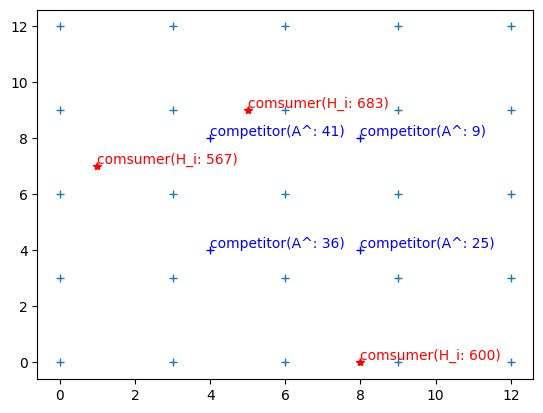

In [3]:
## scale should be 'S', 'M' or 'L'
## file_id should be 1, 2, 3, ..., 100 (integer)

scale = 'S'
file_id = 1

instance_data = Read_data(scale, file_id)
Plot_data(instance_data)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-19
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.0.0 23A344)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 139 rows, 137 columns and 421 nonzeros
Model fingerprint: 0x13e559e3
Model has 31 quadratic constraints
Variable types: 109 continuous, 28 integer (28 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+04]
  QMatrix range    [2e-05, 7e+02]
  QLMatrix range   [9e-03, 2e+04]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 1e+04]
Presolve removed 54 rows and 3 columns
Presolve time: 0.00s
Presolved: 115 rows, 143 columns, 401 nonzeros
Presolved model has 28 quadratic constraint(s)
Presolved model has 6 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 118 continuous, 25 integer (25 binary)
Found heuristic solution: obj

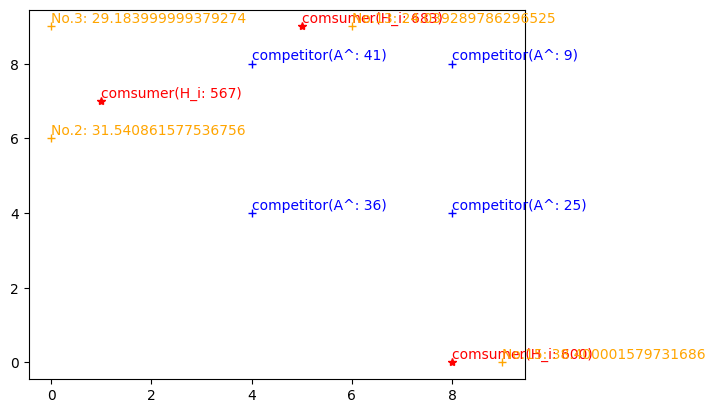

In [4]:
Original_refined(DATA=instance_data, show_detail=True)